# Guided Project : Analyzing NYC High School Data

## Introduction

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests like the SAT, and whether they're unfair to certain groups.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

In this project, we will investigate the correlations between SAT scores and demographics and see if we can spot any trends that would confirm the unfairness of such a test.

### Summary

From our analysis of the data, we are able to conclude that the strongest correlation to SAT scores is with ethnical background. In fact, black or hispanic students tend to have lower SAT scores than their fellow white and asian students.

It is commonly agreed that the US is a quite inegalitarian society, where access to wealth, health, justice and education strongly depends on your ethnical affiliation.
Black and hispanic students tend, on average, to live and study in poorer suburbs, where schools have less fundings, where safety is not always guaranteed and where the education is in general of lower standards.
All these factors have in turn a strong influence on these students SAT score.

## The SAT

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). 

Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

## The Data

New York City makes its data on high school SAT scores available online, as well as the demographics for each high school.

Combining both of these data sets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:
- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these data sets are interrelated. We'll need to combine them into a single data set before we can find correlations.

Before manipulating the datasets and analyzing the data, a thorough understanding of the context is needed in order to avoid any costly mistakes. A background research also gives us a better understanding of how to combine and analyze the data.

The following key points can be extracted from this background research:
- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.
- Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN, or district borough number.
- Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

Now we understand the data and know where to get them, let's read them in!

## Data Import

All the datasets mentioned in the previous section were downloaded as `CSV` files and are stored in the `schools` folder. Here are all the files in this folder:
- `ap_2010.csv` - Data on AP test results
- `class_size.csv` - Data on class size
- `demographics.csv` - Data on demographics
- `graduation.csv` - Data on graduation outcomes
- `hs_directory.csv` - A directory of high schools
- `sat_results.csv` - Data on SAT scores
- `survey_all.txt` - Data on surveys from all schools
- `survey_d75.txt` - Data on surveys from New York City district 75

`survey_all.txt` and `survey_d75.txt` are in more complicated formats than the other files. In the following code block, we focus on reading in the `CSV` files only.

We'll read each file into a pandas dataframe, and then store all of the dataframes in a dictionary. This will give us a convenient way to store them, and a quick way to reference them later on.

In [88]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

We then import the surveys data stored as `txt` files 

In [89]:
# Reading and concatenation of both surveys data
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

## Data Exploration

In this section, we explore the datasets we just imported to to familiarize with the data and check for any necesseray cleaning actions.

What we're mainly interested in is the SAT data set, which corresponds to the dictionary key `sat_results`. This data set contains the SAT scores for each high school in New York City. We eventually want to correlate selected information from this data set with information in the other data sets.

We then start by exploring the `sat_results` dataset.

In [90]:
data["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


<ins>Observations</ins>:
- The DBN appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores -- `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` -- into a single column to make the scores easier to analyze.

Given these observations, let's explore the other data sets to see if we can gain any insight into how to combine them.

We continue our exploration by having a look at the `class_size` dataset.

In [91]:
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


<ins>Observations</ins>:
- There is no column for the DBN ID. However, the `CSD`, `BOROUGH` and `SCHOOL CODE` columns seem to contain the information to create it.

Next, we look at the `demographics` dataset.

In [92]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,38,52,29,38,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.8,57.0,20.3,25,9,10,3.6,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,34,42,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,15.6,55.0,22.6,19,15,18,7.4,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,38,47,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,19.9,60.0,23.0,20,14,16,6.1,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,34,39,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,19.0,62.0,24.6,21,17,16,6.3,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,30,24,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,19.2,46.0,22.1,14,14,16,7.7,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


<ins>Observations</ins>:
- This dataset features a `DBN` column. That could be the appropriate key to join this dataframe to the `sat_results` one.
- It contains data on the ethnical and gender representations per school which can prove useful for our analyzis.

In [93]:
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,0,0%,0%,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,0,0%,0%,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,0,0%,0%,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


<ins>Observations</ins>:
- This dataset contains a `DBN` column that will allow us to join this dataframe with the `sat_results` one.
- It also includes several columns containing graduation or dropout rates that may help us in our analyzis.

In [94]:
data["hs_directory"].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,"B41, B43, B44-SBS, B45, B48, B49, B69","2, 3, 4, 5, F, S to Botanic Garden ; B, Q to P...",883 Classon Avenue,Brooklyn,NY,11225,Bkmusicntheatre.com,399.0,Prospect Heights Educational Campus,NaN,Brooklyn School for Music & Theatre (BSMT) use...,We offer highly competitive positions in our D...,Spanish,"English Language and Composition, United State...",NaN,NaN,"Variety of clubs: Chess, The Step Team, Fashio...","Baseball, Basketball & JV Basketball, Cross Co...","Basketball, Cross Country, Indoor Track, Outdo...",NaN,NaN,F.Y.R.EZONE (Finding Your Rhythm thru Educatio...,NaN,NaN,"In 2002, Roundabout Theatre was selected by Ne...",One To World‘s Global Classroom connects New Y...,NaN,NaN,NaN,NaN,NaN,8:10 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,"Bx13, Bx15, Bx17, Bx21, Bx35, Bx4, Bx41, Bx4A,...","2, 5 to Intervale Ave",1110 Boston Road,Bronx,NY,10456,www.hsvd.org,378.0,Morris Educational Campus,NaN,The High School for Violin and Dance (HSVD) is...,Freshmen take both violin and dance; College N...,Spanish,NaN,NaN,NaN,Advancement via Individual Determination (AVID...,"Baseball, Basketball & JV Basketball, Volleyball","Basketball, Softball, Volleyball",NaN,Morris Educational Campus Basketball and Volle...,McGraw Hill - Big Brother Big Sister,NaN,"Hostos Community College, Monroe College, Teac...",Bronx Arts Ensemble,buildOn,Print International,NaN,Bronx Cares,Our students are required to take four years o...,"Student Summer Orientation, Summer Internship ...",8:00 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Bronx students or residents who at...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026..."
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,"Bx1, Bx11, Bx13, Bx18, Bx2, Bx3, Bx32, Bx35, Bx36","4 to Mt Eden Ave ; B, D to 170th St",1501 Jerome Avenue,Bronx,NY,10452,http://schools.nyc.gov/schoolportals/09/X327,543.0,DOE New Settlement Community Campus,NaN,At the Comprehensive Model School Project (CMS...,"After-school and Saturday Tutoring, Advisory, ...",Spanish,"Biology, Chemistry, United States History",NaN,NaN,"Choir, Gaming, Girls Club, Newspaper, Spanish,...",NaN,NaN,NaN,"As we expand, we plan to offer PSAL sports.",New Settlement Community Center,Montefiore Hospital,NaN,NaN,NaN,NaN,NaN,NaN,Dress Code Required: white or baby blue button...,NaN,8:00 AM,4:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Bronx students or residents who attend...,Then to New York City residents who attend an ...,Then to Bronx stud

<ins>Observations</ins>:
- The dataset also contains a `DBN` column that will help us join the dataframes.
- The last column contains schools location data. These data could help us analyze and better visualize the disparities in education level (revealed by the SAT score) between the different areas of New York.
- Most of the other columns won't prove useful and we will need to get rid of them.

To finish with, let's have a look at the two surveys datasets.

In [95]:
all_survey.head()

dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p    N_s   N_t  \
0         0.0           Elementary School   NaN    88    60    NaN  22.0   
1         0.0           Elementary School   NaN   100    60    NaN  34.0   
2         0.0           Elementary School   NaN    88    73    NaN  42.0   
3         0.0  Elementary / Middle School  89.0    73    50  145.0  29.0   
4         0.0           Elementary School   NaN   100    60    NaN  23.0   

     N_p  nr_s  nr_t  nr_p  saf_p_11  com_p_11  eng_p_11  aca_p_11  saf_t_11  \
0   90.0     0    25   150       8.5       7.6       7.5       7.8       7.5   
1  161.0     0    33   269       8.4       7.6       7.6       7.8       8.6   
2  367.0     0    48   505       8.9       8.3       8.3       8.6       7.6   
3  151.0   163    40   301       8.8       8.2       8.0       8.5       7.0   
4   90.0     0    23   151       8.7       7.9       8.1       7.9       8.4   

   com_t_11  eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0       7.8       7.6       7.9       NaN       NaN       NaN       NaN   
1       8.5       8.9       9.1       NaN       NaN       NaN       NaN   
2       6.3       6.8       7.5       NaN       NaN       NaN       NaN   
3       6.2       6.8       7.8       6.2       5.9       6.5       7.4   
4       7.3       7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11  p_q2h  p_q7a  p_q7b  p_q7c  \
0         8.0         7.7         7.5         7.9    8.0    8.2    8.3    7.5   
1         8.5         8.1         8.2         8.4    7.7    7.9    8.0    7.3   
2         8.2         7.3         7.5         8.0    8.1    8.8    8.9    8.5   
3         7.3         6.7         7.1         7.9    8.1    8.5    8.8    8.2   
4         8.5         7.6         7.9         8.0    8.0    8.4    8.6    8.0   

   p_q7d  p_q8a  p_q8b  p_q8c  p_q8d  p_q8e  p_q8f  p_q2b  p_q2d  p_q2e  \
0    7.9    6.8    8.7    9.7    8.7    9.9    9.9    7.7    8.3    7.9   
1    7.7    6.5    8.8    9.4    8.7   10.0    9.9    7.5    8.2    7.9   
2    8.4    7.6    9.2    9.4    9.2    9.8    9.7    8.4    8.8    8.5   
3    8.3    7.3    9.2    9.4    9.1    9.8    9.7    8.3    8.7    8.3   
4    8.0    6.5    8.8    9.6    9.4   10.0   10.0    7.6    8.5    8.0   

   p_q2f  p_q2g  p_q3a  p_q3b  p_q4b  p_q4c  p_q11c  p_q2a  p_q2c  p_q3c  \
0    8.1    7.5    7.3    6.7    7.6    7.9     7.5    8.0    7.4    8.7   
1    8.0    7.2    7.0    6.9    8.0    8.4     7.4    7.6    7.1    9.0   
2    8.3    8.0    7.6    7.3    8.6    8.7     8.4    8.8    8.2    8.8   
3    8.1    7.6    7.6    7.5    8.6    8.6     8.4    8.5    8.1    8.8   
4    8.2    7.4    7.8    7.2    8.1    7.9     7.8    8.2    8.3    9.2   

   p_q6a  p_q6b  p_q11d  p_q11e  p_q5  p_q4a  p_q4d  p_q4e  p_q11a  p_q11b  \
0    6.3    6.6     7.6     7.6   7.4    7.8    7.4    NaN     8.3     7.5   
1    6.4    6.5     7.6     7.8   8.6    7.7    7.8    NaN     8.3     7.6   
2    7.9    6.8     8.5     8.5   8.7    8.6    8.5    NaN     8.9     8.4   
3    7.3    6.8     8.2     8.3   8.0    8.7    8.3    NaN     8.8     8.3   
4    7.4    7.0     7.9     7.9   8.8    8.2    7.8    NaN     8.1     7.6   

   p_q11f  p_q1  p_q3d  p_q9  p_q10  p_q12aa  p_q12ab  p_q12ac  p_q12ad  \
0     7.7   NaN    NaN   NaN    NaN      NaN      NaN      NaN      NaN   
1     7.7   NaN    NaN   NaN    NaN      NaN      NaN      NaN      NaN   
2     8.6   NaN    NaN   NaN    NaN      NaN      NaN      NaN      NaN   
3     8.5   Na

<ins>Observations</ins>:
- This dataset contains a `dbn` column which will allow us to join this dataframe with the others. In the cleaning section, we will convert this column name to uppercase to make it match the similar columns in the other datasets.
- There are nearly 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.

In [96]:
d75_survey.head()

dbn    bn schoolname  d75 studentssurveyed  highschool  \
0  75K004  K004  P.S. K004    1              Yes         0.0   
1  75K036  K036    P.S. 36    1              Yes         NaN   
2  75K053  K053  P.S. K053    1              Yes         NaN   
3  75K077  K077  P.S. K077    1              Yes         NaN   
4  75K140  K140  P.S. K140    1              Yes         0.0   

                      schooltype  rr_s  rr_t  rr_p    N_s  N_t  N_p  nr_s  \
0  District 75 Special Education  38.0    90    72    8.0   81  244    21   
1  District 75 Special Education  70.0    69    44   97.0   43  115   139   
2  District 75 Special Education  94.0    97    53  131.0   75  189   139   
3  District 75 Special Education  95.0    65    55   70.0   52  150    74   
4  District 75 Special Education  77.0    70    42   69.0   45  117    90   

   nr_t  nr_p  saf_p_11  com_p_11  eng_p_11  aca_p_11  saf_t_11  com_t_11  \
0    90   337       9.1       8.6       8.4       8.5       7.4       6.6   
1    62   263       9.2       8.7       8.6       8.8       6.9       7.1   
2    77   355       8.8       8.1       8.0       8.1       7.8       7.5   
3    80   274       9.4       8.7       8.8       8.9       7.1       6.2   
4    64   277       8.6       8.2       7.9       8.3       5.6       5.8   

   eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  saf_tot_11  \
0       6.4       6.4       7.6       5.8       7.6       6.3         8.0   
1       6.1       7.2       6.6       6.9       7.3       7.7         7.5   
2       6.9       8.0       8.2       7.7       8.6       8.5         8.2   
3       6.4       6.3       8.6       8.3       8.6       8.8         8.3   
4       5.1       6.0       4.7       6.1       6.0       7.3         6.3   

   com_tot_11  eng_tot_11  aca_tot_11  p_q1c  p_q10a  p_q10b  p_q10c  p_q10d  \
0         7.0         7.5         7.1    8.7     9.0     9.0     8.9     8.8   
1         7.6         7.3         7.9    8.8     9.3     9.2     9.0     9.1   
2         7.8         7.8         8.2    8.3     8.6     8.8     8.4     8.6   
3         7.7         7.9         8.0    8.8     9.2     9.2     9.1     9.1   
4         6.7         6.3         7.2    8.8     8.6     8.8     8.4     8.4   

   p_q10e  p_q10f  p_q11a  p_q11b  p_q11c  p_q11d  p_q11e  p_q1b  p_q1e  \
0     8.9     8.9     7.3     9.7     9.7     9.9     9.9    8.6    8.4   
1     9.3     9.2     7.6     9.7     8.8    10.0     9.8    9.2    9.0   
2     8.7     8.4     7.3     9.6     9.0     9.7     9.7    8.1    7.9   
3     9.1     8.9     9.5    10.0     9.9    10.0    10.0    9.0    8.7   
4     8.5     8.6     6.4     9.1     8.5     9.9     9.1    8.8    8.6   

   p_q1f  p_q2a  p_q2b  p_q3c  p_q3d  p_q4a  p_q6c  p_q12c  p_q1a  p_q1d  \
0    9.0    9.0    8.6    8.0    8.1    8.9    8.7     8.6    9.0    8.3   
1    9.1    8.4    8.0    8.5    8.2    9.1    8.9     8.7    9.1    8.7   
2    8.5    7.8    7.3    7.9    8.0    8.6    8.1     8.2    8.5    7.6   
3    8.9    8.8    8.0    8.7    8.2    9.3    8.9     8.9    8.9    8.3   
4    8.8    7.7    7.1    8.0    7.7    8.7    8.5     8.3    8.9    8.3   

   p_q3a  p_q3b  p_q3e  p_q4b  p_q4c  p_q6e  p_q7  p_q8a  p_q8b  p_q12d  \
0    8.8    6.9    7.8    8.6    9.1    8.5   8.8    8.0    8.4     8.6   
1    9.1    8.2    7.9    9.0    8.4    8.8   7.9    8.4    8.5     8.8   
2    8.2    7.3    7.6    8.4    8.1    8.0   8.1    7.4    8.1     8.1   
3    8.9    7.9    8.7    9.1    9.2    8.7   9.6    8.8    8.9     8.9   
4    8.3    5.7    7.6    8.0    7.4    8.4   7.9    7.6    7.9     8.3   

   p_q1g  p_q6a  p_q6b  p_q6d  p_q6f  p_q6g  p_q6h  p_q12a  p_q12b  p_q12e  \
0    9.0    8.8    8.9    8.0    8.4    8.3    8.1     8.9     8.6     8.4   
1    9.1    9.0    9.1    8.7    8.9    8.7    8.7     8.9     8.6     8.6   
2    8.6    8.2    8.5    7.7    8.2    7.8    7.9     8.2     8.0     8.0   
3    8.9    8.9    9.1    8.7    8.9    9.0    8.7     9.0     8.9     8.9   
4 

<ins>Observations</ins>:
- This dataset also contains a `dbn` column that will need to be converted.
- Similarly to the `all_survey` dataset, it contains a lot of columns that will prove unnecessary for our analysis.
- Although not containing the exact same number of columns, both `all_survey` and `d75_survey` datasets contain similar data and main columns. We will concatenate both dataframes in the next section.

## Data Cleaning

In this section, we clean the datasets based on the observations we made in the initial data exploration phase.

### `all_survey` and `d75_survey`

We start by concatenating the two datasets

In [97]:
survey = pd.concat([all_survey, d75_survey], axis=0)

We then rename the `dbn` column to make it match the format of the other datasets.

In [98]:
survey["DBN"] = survey["dbn"]

And we finish by filtering the `survey` dataset to only keep the relevant columns.

To help us figure out which columns to keep, we can refer to the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) that is provided at the original data download location. The dictionary tells us what each column represents. 

Based on our knowledge of the problem and the analysis we're trying to do, the following columns seem to be the most relevant:

"dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"

In [99]:
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### `hs_directory`

As observed in the data exploratory section, the `hs_directory` dataframe needs to have the `dbn` column name reformatted to match the formatting of the other datasets.

In [100]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

Next, we want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` data set.

In [101]:
# Function for parsing of the latitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Function for parsing of the longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [102]:
data["hs_directory"].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,"B41, B43, B44-SBS, B45, B48, B49, B69","2, 3, 4, 5, F, S to Botanic Garden ; B, Q to P...",883 Classon Avenue,Brooklyn,NY,11225,Bkmusicntheatre.com,399.0,Prospect Heights Educational Campus,NaN,Brooklyn School for Music & Theatre (BSMT) use...,We offer highly competitive positions in our D...,Spanish,"English Language and Composition, United State...",NaN,NaN,"Variety of clubs: Chess, The Step Team, Fashio...","Baseball, Basketball & JV Basketball, Cross Co...","Basketball, Cross Country, Indoor Track, Outdo...",NaN,NaN,F.Y.R.EZONE (Finding Your Rhythm thru Educatio...,NaN,NaN,"In 2002, Roundabout Theatre was selected by Ne...",One To World‘s Global Classroom connects New Y...,NaN,NaN,NaN,NaN,NaN,8:10 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,"Bx13, Bx15, Bx17, Bx21, Bx35, Bx4, Bx41, Bx4A,...","2, 5 to Intervale Ave",1110 Boston Road,Bronx,NY,10456,www.hsvd.org,378.0,Morris Educational Campus,NaN,The High School for Violin and Dance (HSVD) is...,Freshmen take both violin and dance; College N...,Spanish,NaN,NaN,NaN,Advancement via Individual Determination (AVID...,"Baseball, Basketball & JV Basketball, Volleyball","Basketball, Softball, Volleyball",NaN,Morris Educational Campus Basketball and Volle...,McGraw Hill - Big Brother Big Sister,NaN,"Hostos Community College, Monroe College, Teac...",Bronx Arts Ensemble,buildOn,Print International,NaN,Bronx Cares,Our students are required to take four years o...,"Student Summer Orientation, Summer Internship ...",8:00 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Bronx students or residents who at...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,"Bx1, Bx11, Bx13, Bx18, Bx2, Bx3, Bx32, Bx35, Bx36","4 to Mt Eden Ave ; B, D to 170th St",1501 Jerome Avenue,Bronx,NY,10452,http://schools.nyc.gov/schoolportals/09/X327,543.0,DOE New Settlement Community Campus,NaN,At the Comprehensive Model School Project (CMS...,"After-school and Saturday Tutoring, Advisory, ...",Spanish,"Biology, Chemistry, United States History",NaN,NaN,"Choir, Gaming, Girls Club, Newspaper, Spanish,...",NaN,NaN,NaN,"As we expand, we plan to offer PSAL sports.",New Settlement Community Center,Montefiore Hospital,NaN,NaN,NaN,NaN,NaN,NaN,Dress Code Required: white or baby blue button...,NaN,8:00 AM,4:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Bronx students or residents who attend...,

### `class_size`

The `class_size` dataset doesn't feature a `DBN` column but has all the information available to create it.

In the following block of code, we use the `CSD` and `SCHOOL CODE` columns to create a `DBN` column.

In [103]:
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


Looking at the newly created `DBN` column, we can see that there are duplicate DBN values.

If we later want to combine this dataframe with others based on the `DBN` column, we need to get rid of these duplicates.

It looks like each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`.

If we look at the unique values for `GRADE`, we get the following:

In [104]:
data["class_size"]["GRADE "].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the `GRADE` column is `09-12`.

In [105]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]

If we now look at the unique values for `PROGRAM TYPE`, we get the following:

In [106]:
class_size["PROGRAM TYPE"].value_counts()

GEN ED     6513
CTT        2953
SPEC ED    1178
Name: PROGRAM TYPE, dtype: int64

Each school can have multiple program types. Because `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` is `GEN ED`.

In [107]:
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

Let's now check the value counts on the `DBN` column.

In [108]:
class_size["DBN"].value_counts()

09X505    21
20K505    21
25Q425    20
26Q435    20
20K490    20
22K495    20
24Q485    20
21K540    20
30Q445    20
21K525    20
13K670    19
27Q480    19
01M539    19
28Q470    19
19K409    19
12X278    19
31R460    19
20K445    19
10X445    19
18K563    19
02M475    19
11X545    19
08X405    19
02M655    19
22K405    19
26Q415    19
10X696    19
21K410    19
26Q495    19
26Q430    19
06M540    19
31R445    19
13K430    19
21K690    19
03M470    19
25Q460    19
30Q575    19
31R455    19
25Q285    19
27Q410    19
10X440    19
30Q450    19
03M492    18
02M529    18
27Q400    18
13K419    18
14K561    18
27Q475    18
24Q550    18
10X374    18
07X548    18
02M615    18
25Q670    18
22K425    18
06M467    18
28Q680    18
02M416    18
26Q566    18
11X455    18
10X442    18
27Q308    18
31R080    18
28Q620    18
07X500    18
14K478    18
04M435    18
17K600    18
02M489    18
31R440    18
17K546    18
24Q610    18
24Q455    18
20K485    18
29Q265    18
02M460    17
28Q440    17
29Q494    17

As we can see, the `DBN` still isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns.

`CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` seem to pertain to different kinds of classes. For example, here are the unique values for `CORE SUBJECT (MS CORE and 9-12 ONLY)`:

In [109]:
class_size["CORE SUBJECT (MS CORE and 9-12 ONLY)"].value_counts()

ENGLISH           1977
SCIENCE           1636
SOCIAL STUDIES    1453
MATH              1447
Name: CORE SUBJECT (MS CORE and 9-12 ONLY), dtype: int64

This column only seems to include certain subjects. We want our class size data to include every single class a school offers, not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique `DBN` values, while also incorporating as much data as possible into the average.

In the next block of code, we then aggregate the rows by the `DBN` column, retaining the average of the other numeric columns.

In [110]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

### Summation of scores in `sat_results`

For our analyzis, we would like to be able to correlate a single variable with different demographic factors.

In the `sat_results` dataset, we have three score columns corresponding to the scores for each three section of the SAT. Summing these three scores to give us a unique total SAT score will make it much easier for us later on in our analysis.

In the next block of code, we sum these three columns and create a new column named `sat_score` to store the result.

But before we an generate this column, we need to convert the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the `sat_results` data set from the object (string) data type to a numeric data type.

In [111]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

### `demographics`

For this dataframe, no particular cleaning is needed. However, we can observed that several rows feature the same DBN code. This will pose a problem when trying to merge the dataframes between each other.

The only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [112]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

### `graduation`

Similarly to the `demographics` dataframe, the `graduation` dataframe features rows with the same DBN code. We need to condense this dataset as well.

The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the `graduation` data. A cohort appears to refer to the year the data represents, and the demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent cohort available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [113]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### `ap_2010`

For the `ap_2010` dataframe, we only need to convert a few columns to numeric type.

In [114]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combination of the datasets

Now that the dataframes are clean and all possess the same `DBN` joining key column, we can merge them together.

Because this project is concerned with determing demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values.

This means that we may need to use different merge strategies with different data sets. 

Both the `ap_2010` and the `graduation` data sets have many missing DBN values, so we'll use a left join when we merge the `sat_results` data set with them to not lose too many schools. Because we're using a left join, our final dataframe will have all of the same DBN values as the original `sat_results` dataframe.

`class_size`, `demographics`, `survey`, and `hs_directory` contain information that's more valuable to our analysis and also have fewer missing DBN values, so we'll use the inner join type.

In [115]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

In [116]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,NaN,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.000000,4.000000,22.564286,18.500000,26.571429,NaN,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,NaN,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.0,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,NaN,NaN,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,NaN,NaN,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,NaN,NaN,United Nations,NaN,NaN,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HI

In [117]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Columns: 159 entries, DBN to lon
dtypes: float64(51), int64(12), object(96)
memory usage: 453.8+ KB


Merging all the dataframes one after the other with different merging strategies inevitably resulted in the apparition of NaNs in some columns.

Though there are a lot of different and more complex ways to handle missing data, we choose here to fill in the missing values with the overall mean for each column.

Any remaining NaN or null values after the initial replacement is filled with the value 0.

In [118]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Creation of a school district column for mapping

We've finished cleaning and combining our data! We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the `DBN`. We can apply a function over the `DBN` column of `combined` that pulls out the first two letters.

In [119]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
combined["school_dist"].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

## Data Analysis

In this section, we analyse our cleaned dataset.

We first start by calculating the correlation between the SAT score and all the other factors of the dataframe.

### Correlations with SAT Scores

In [120]:
correlations = combined.corr()
correlations = correlations["sat_score"]

pd.set_option("display.max_rows", None, "display.max_columns", None)
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score` and `SAT Writing Avg. Score` are strongly correlated with `sat_score`.

We can also make some other observations:

- `total_enrollment` has a strong positive correlation with `sat_score`. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
     - Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
- Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- Student ratings of school academic standards (`aca_s_11`) correlate with sat_score, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
- There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).
- The percentage of English language learners at the school (`ell_percent`, `frl_percent`) has a strong negative correlation with SAT scores.

### Total Enrollment vs SAT Scores

Because enrollment seems to have such a strong correlation, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

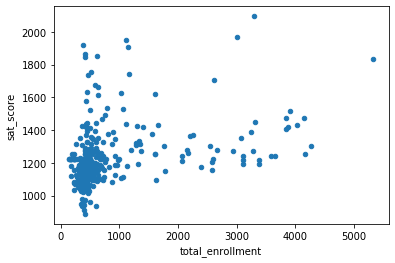

In [121]:
combined.plot.scatter(x='total_enrollment', y='sat_score')

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between `sat_score` and `total_enrollment`. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [122]:
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000)]

low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Further research on these high schools revealed that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually `ell_percent` that correlates strongly with `sat_score`, rather than `total_enrollment`.

### Correlations of Survey Factors with SAT Scores

In this section, we analyse the correlation between the survey factors and the SAT score.

In [123]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

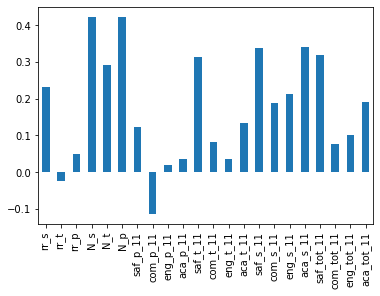

In [124]:
correlations[survey_fields].plot.bar()

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_s_11` and `saf_t_11`) correlates with `sat_score`. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is between `aca_s_11`, which indicates how the student perceives academic standards, and `sat_score`. However, this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

### Borough Safety

Next, we want to further investigate the relation between the feeling of safety reported by students and the average SAT scores of their high school.

For that, we group our data by borough and average on the `saf_s_11` column.

In [135]:
boros = combined.groupby('boro').agg(np.mean)[['saf_s_11','sat_score']]
print(boros)

               saf_s_11    sat_score
boro                                
Bronx          6.606577  1157.598203
Brooklyn       6.370755  1181.364461
Manhattan      6.831370  1278.331410
Queens         6.721875  1286.753032
Staten Island  6.530000  1382.500000


It looks like Manhattan and Queens tend to have higher reported safety scores contrary to Brooklyn and the Bronx.

We can also observe that Brooklyn, which has the lowest reported safety score also has the second lowest average SAT score.

No conclusion can be made however linking the feeling of insecurity to lower SAT scores as we can see that Staten Island has the second lowest safety score but the highest SAT score.
Though there may be a correlation, multiple other factors maybe interfering here.

### Racial Differences in SAT Scores

In this section, we want to see if the ethnical background infers has an impact on the SAT scores. For that, we start by plotting the correlation to SAT score for all four ethnical categories in our dataset.

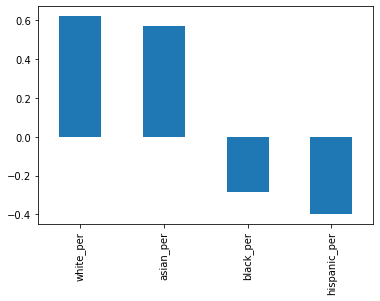

In [127]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

To investigate that further, we plot the average SAT score for each high school versus the percentage of hispanic students.

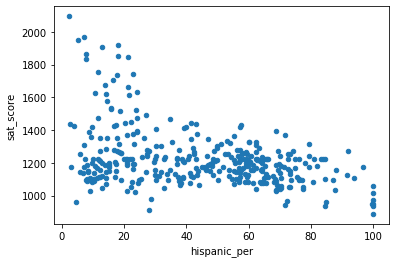

In [128]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

There is no strong linear relationship. However, we can see several high schools with a low percentage of hispanic students doing really well at the SAT. On the other end, we can see a bunch of schools who are predominantly hispanic and who have low SAT scores.

The names of the high schools with more than 95% hispanic students are the following:

In [129]:
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

On the other end, let's print the names of the schools that have high SAT scores and low percentages of hispanic students.

In [130]:
print(combined[(combined['hispanic_per'] < 10)&(combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Gender Differences in SAT Scores

We also want to verify if the SAT is biased towards a particular gender.

The following plot shows the correlation to SAT scores of each gender.

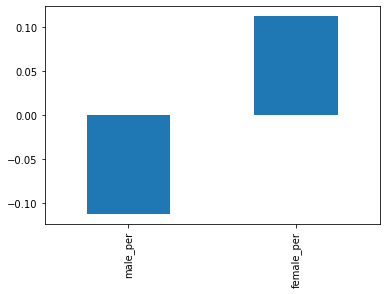

In [131]:
correlations[['male_per','female_per']].plot.bar()

We can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

To verify that, we can make a scatter plot of the SAT score versus the percentage of females for each high school.

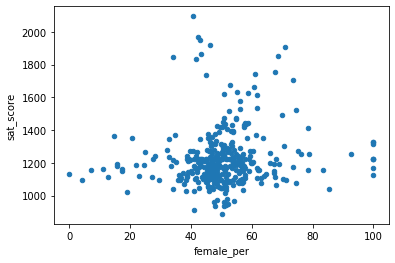

In [132]:
combined.plot.scatter(x='female_per', y='sat_score')

Based on this scatterplot, there doesn't seem to be any real strong correlation between sat_score and female_per. 

However, there are a few schools with a relatively high percentage of females (60 to 80), and high SAT scores. Let's print the name of these schools and investigate them.

In [133]:
print(combined[(combined['female_per'] > 60)&(combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After some research, these schools appear to be very selective liberal arts schools that have high academic standards, explaining both the high percentage of females and the high scores.

### Percentage of AP Test Takers vs SAT Scores

In this section, we want to analyse the possible relation between the percentage of AP test takers and the SAT scores.

We would expect high schools with a high percentage of AP test takers to also have high average SAT scores. In fact, these would be schools with high academic standards that also have more means to focus on students.

We calculate the percentage of AP test takers by dividing the number of AP test takers by the total enrollment for each high school.

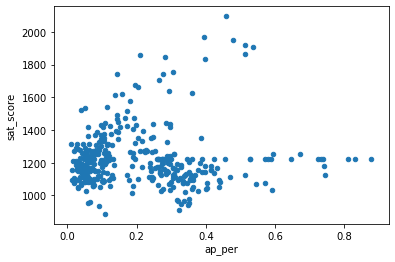

In [134]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter(x='ap_per', y='sat_score')


It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

## Conclusion

In this project, we analysed the correlation between different demographics and SAT scores for NYC high schools.

From our analysis of the data, we are able to conclude that the strongest correlation to SAT scores is with ethnical background. In fact, black or hispanic students tend to have lower SAT scores than their fellow white and asian students.

It is commonly agreed that the US is a quite inegalitarian society, where access to wealth, health, justice and education strongly depends on your ethnical affiliation.
Black and hispanic students tend, on average, to live and study in poorer suburbs, where schools have less fundings, where safety is not always guaranteed and where the education is in general of lower standards.
All these factors have in turn a strong influence on these students SAT score.